# GateCount: Profiling

This notebook profiles the GateCount files.

## Setup

In [15]:
# Libraries.
import datetime as dt
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [13]:
# Setup.
% matplotlib inline

# Paths.
path_data = '../../../data/gatecount_%d/'

# Plot sizes.
default_figsize = (12,8)
default_figsize_slide = (12,6)

## Loading &amp; Cleaning

In [2]:
# Get all filenames.
years = [2013,2014,2015]
gc_files = []
for year in years:
    year_files = [(path_data % year + f) for f in os.listdir(path_data % year) if f[-4:] == '.csv']
    gc_files = gc_files + year_files
    
# Load all files as DFs and concatenate.
gate_count = [pd.read_csv(path) for path in gc_files]
gate_count = pd.concat(gate_count)
gate_count.reset_index(inplace=True,drop=True)

## Structure

In [3]:
# Start with the head.
print 'Head:'
gate_count.head()

Head:


,locationid,servicedate,servicetime,entries,exits
0,1002,2013-01-01,300,0,1
1,1002,2013-01-01,500,1,0
2,1002,2013-01-01,515,2,0
3,1002,2013-01-01,530,3,0
4,1002,2013-01-01,545,6,0


In [4]:
# Show types.
print 'Types:'
print gate_count.dtypes
# Show nulls.
print '\nNulls:'
print np.sum(gate_count.isnull())
# Show min/max service times.
print '\nMin service time: %d' % gate_count.servicetime.min()
print 'Max service time: %d' % gate_count.servicetime.max()
# Num records.
print '\nNumber of records: %d' % len(gate_count)

Types:
locationid      int64
servicedate    object
servicetime     int64
entries         int64
exits           int64
dtype: object

Nulls:
locationid     0
servicedate    0
servicetime    0
entries        0
exits          0
dtype: int64

Min service time: 300
Max service time: 2645

Number of records: 3982009


**3.98 million records**

Data looks relatively clean. 0 nulls.

### Clean Up Dates

Dates are currently strings and integers. We'll want to use formal date/time representations for them.

In [5]:
# Convert main date column.
gate_count.servicedate = pd.to_datetime(gate_count.servicedate)

# Add a calendar date column.
gate_count['calendardate'] = gate_count['servicedate']
# Increment dates after midnight.
gate_count.ix[gate_count['servicetime'] >= 2400,'calendardate'] = gate_count.ix[gate_count['servicetime'] >= 2400,'calendardate']+np.timedelta64(1,'D')

# Add a calendar time minutes column and put on proper scale.
gate_count['calendartimeminutes'] = (np.floor((gate_count.servicetime) / 100)*60 + np.mod(gate_count.servicetime,100)) % (24.*60.)
# Convert to hours as well.
gate_count['calendartimehours'] = gate_count['calendartimeminutes'].astype(np.float) / 60

# Populate our dedicated datetime column with converted servicedate values.
gate_count['calendardatetime'] = gate_count.calendardate
# Add the timedeltas.
gate_count['calendardatetime'] += np.array(gate_count.calendartimeminutes, dtype='timedelta64[m]')

In [6]:
# Show head to make sure we have what we're looking for.
gate_count.head()

,locationid,servicedate,servicetime,entries,exits,calendardate,calendartimeminutes,calendartimehours,calendardatetime
0,1002,2013-01-01,300,0,1,2013-01-01,180,3.00,2013-01-01 03:00:00
1,1002,2013-01-01,500,1,0,2013-01-01,300,5.00,2013-01-01 05:00:00
2,1002,2013-01-01,515,2,0,2013-01-01,315,5.25,2013-01-01 05:15:00
3,1002,2013-01-01,530,3,0,2013-01-01,330,5.50,2013-01-01 05:30:00
4,1002,2013-01-01,545,6,0,2013-01-01,345,5.75,2013-01-01 05:45:00


## Summary Statistics

In [7]:
# Metric totals.
print 'Total entries:        ',gate_count.entries.sum()
print 'Total exits:          ',gate_count.exits.sum()
print 'Ratio (entries/exits):',float(gate_count.entries.sum())/gate_count.exits.sum()

Total entries:         322966487
Total exits:           267648718
Ratio (entries/exits): 1.20668049305


**320 million** entries, **270 million** exits. Remember, data is not annual (it includes Jan and part of Feb 2015). Looks like roughly **6 entries per 5 exits**.

## Distributions

Charts below show distributions at various levels of aggregation: non-aggregated (effectively by location and date/time), by date, and by location/date.

In [8]:
# Store several convenient distributions.

# Date.
gate_count_by_date = gate_count[['calendardate','entries','exits']].groupby('calendardate').agg(np.sum)

# Location-date.
gate_count_by_location_date = gate_count[['locationid','calendardate','entries','exits']].groupby(['locationid','calendardate']).agg(np.sum)

# Time.
gate_count_by_time = gate_count[['calendartimehours','entries','exits']].groupby('calendartimehours').agg(np.sum)

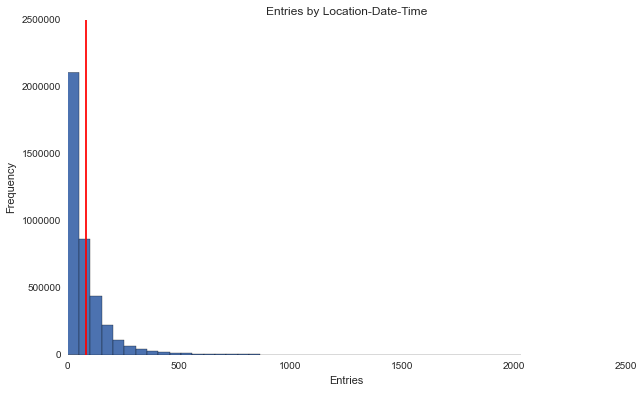

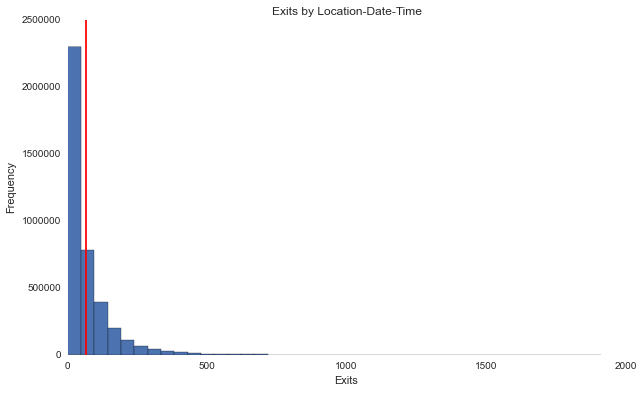

In [9]:
# Plot distribution of entries.
plt.figure(figsize=(10,6))
plt.hist(gate_count.entries, bins=40)
plt.vlines(gate_count.entries.mean(),0,plt.ylim()[1],colors='r')
plt.title('Entries by Location-Date-Time')
plt.xlabel('Entries') ; plt.ylabel('Frequency')
plt.show()

# Plot distribution of exits.
plt.figure(figsize=(10,6))
plt.hist(gate_count.exits, bins=40)
plt.vlines(gate_count.exits.mean(),0,plt.ylim()[1],colors='r')
plt.title('Exits by Location-Date-Time')
plt.xlabel('Exits') ; plt.ylabel('Frequency')
plt.show()

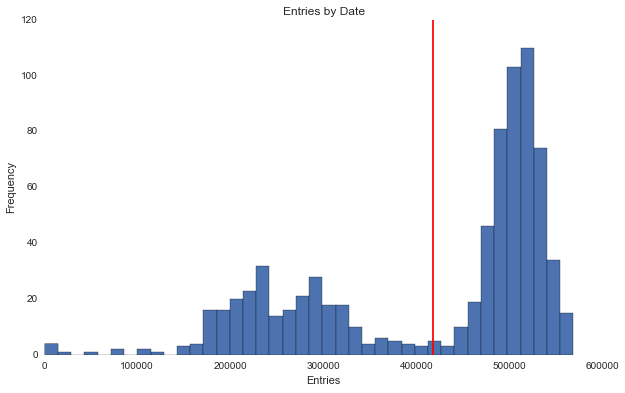

In [10]:
# Plot distribution of entries.
plt.figure(figsize=(10,6))
plt.hist(gate_count_by_date.entries, bins=40)
plt.vlines(gate_count_by_date.entries.mean(),0,plt.ylim()[1],colors='r')
plt.title('Entries by Date')
plt.xlabel('Entries') ; plt.ylabel('Frequency')
plt.show()

Exits looks similar. Note that there are probably both annual and weekly trends meshed together here. The latter predicts a bimodal distribution.

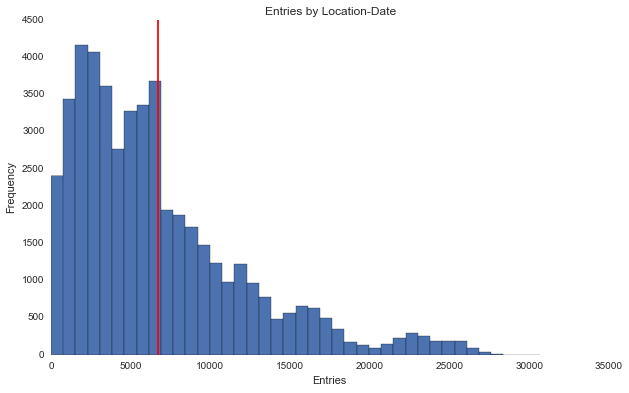

In [11]:
# Plot distribution of entries.
plt.figure(figsize=(10,6))
plt.hist(gate_count_by_location_date.entries, bins=40)
plt.vlines(gate_count_by_location_date.entries.mean(),0,plt.ylim()[1],colors='r')
plt.title('Entries by Location-Date')
plt.xlabel('Entries') ; plt.ylabel('Frequency')
plt.show()

## Time Trends

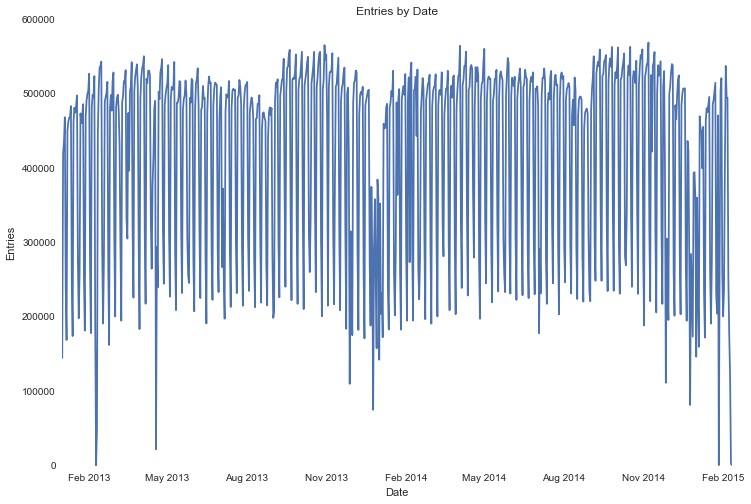

In [12]:
# Plot entries by date.
plt.figure(figsize=(12,8))
plt.plot(gate_count_by_date.index,gate_count_by_date.entries)
plt.title('Entries by Date')
plt.xlabel('Date') ; plt.ylabel('Entries')
plt.show()

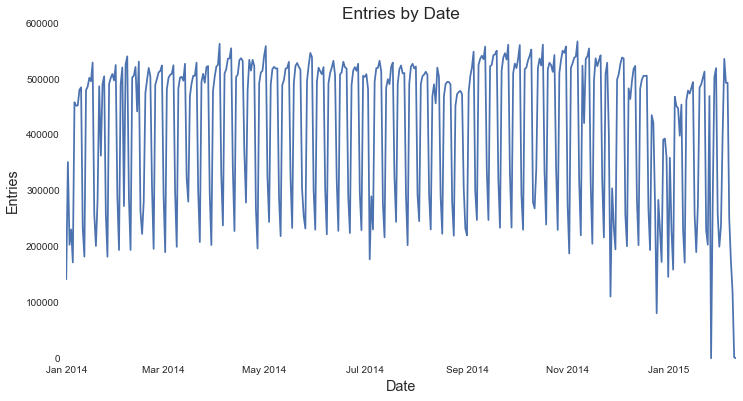

In [22]:
# Repeat just for 2014.
days_2014 = (gate_count_by_date.index >= dt.datetime(2014,1,1))

# Plot entries by date.
plt.figure(figsize=default_figsize_slide)
plt.plot(gate_count_by_date[days_2014].index,gate_count_by_date[days_2014].entries)
plt.title('Entries by Date', fontsize='xx-large')
plt.xlabel('Date', fontsize='x-large') ; plt.ylabel('Entries', fontsize='x-large')
plt.show()

Pretty obvious weekday-weekend divide.

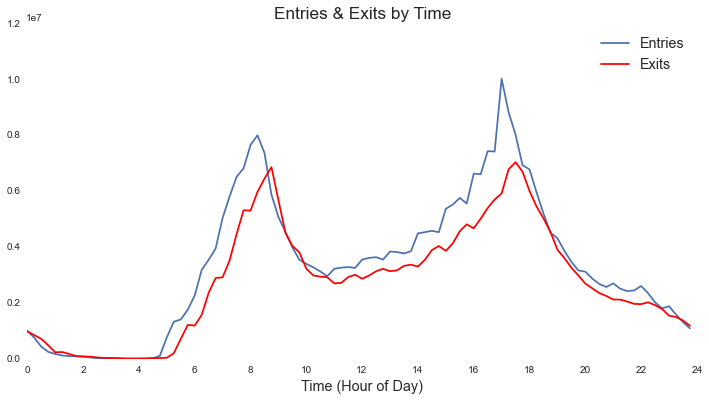

In [28]:
# Plot entries, exits by time. Very rough plot (only using minutes of day).
plt.figure(figsize=default_figsize_slide)
plt.plot(gate_count_by_time.index, gate_count_by_time.entries,      label='Entries')
plt.plot(gate_count_by_time.index, gate_count_by_time.exits,   'r', label='Exits')
plt.title('Entries & Exits by Time', fontsize='xx-large')
plt.xlabel('Time (Hour of Day)', fontsize='x-large')
plt.xticks(np.arange(0,25,2))
plt.xlim((0,24))
plt.legend(fontsize='x-large')
plt.show()

Overlap between entries and exits looks pretty intuitive: in the aggregate, people enter and then seem to exit somewhat later. We lose some exits due to gates staying open for >1 person and people getting off in ways that aren't tracked. But visually, it looks like we "lose" more exits later in the day. I wonder if that happens as people board through a subway entrance but exit (untracked) off of the Green Line. Maybe farther-out stops have more exits without gates.

Also, it looks like orignial `servicetime` values < 2400 are all accurate and that values ≥ 2400 actually represent times after midnight. A morning peak at ~300 (as shown) is 5am; adding three hours would put the morning peak at 8am (much more reasonable). So to clean up times, we should *not* simply subtract 300.